In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.stats.stats import pearsonr

In [15]:
# Import the master dataset.
data = pd.read_excel('master_dataset.xlsx')
data.columns = ['STATE', 'Total_Population', 'Number_of_Poor', 'Poverty_Rate', 'Year', 'Mortality_Rate']

# Initial Visualizations

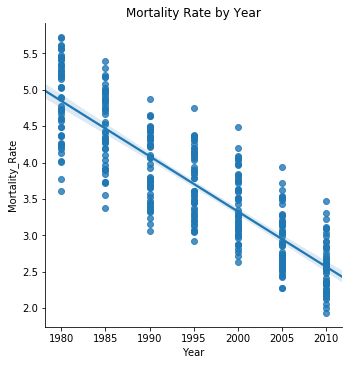

In [4]:
# Let's graph the mortaility rate by year to see if there are any trends.
g1 = sns.lmplot('Year', 'Mortality_Rate', data=data)
plt.title('Mortality Rate by Year')
plt.show()

There is a clear downward trend of the mortality rate over time.  Let's graph each State's overall trend.

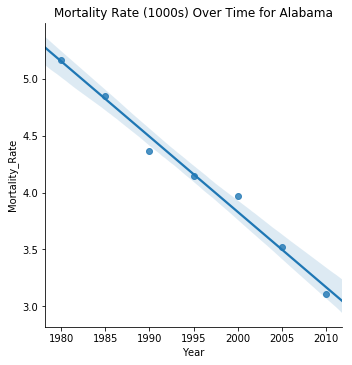

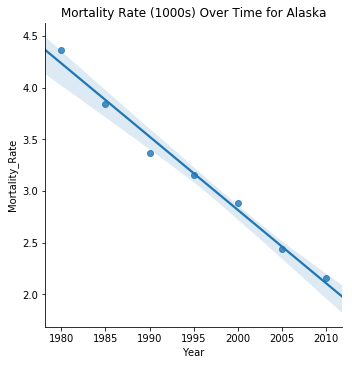

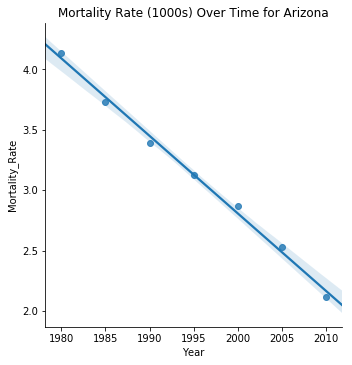

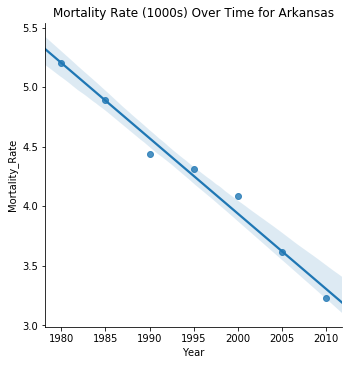

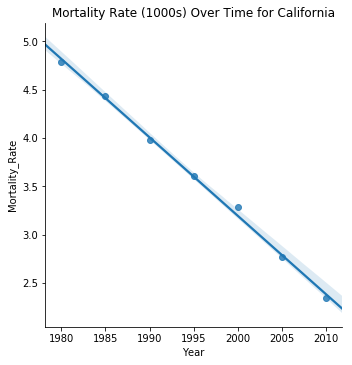

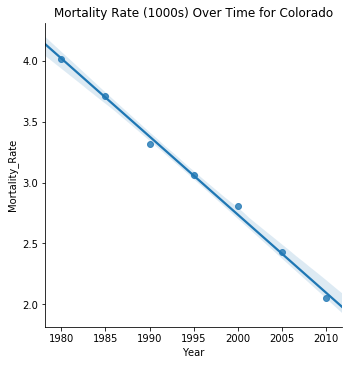

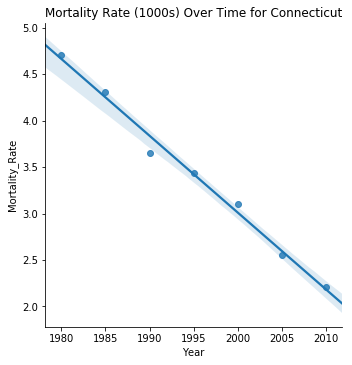

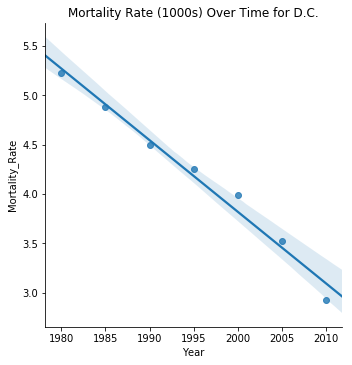

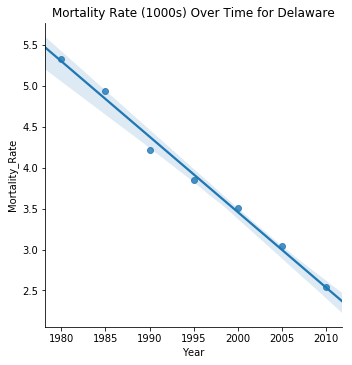

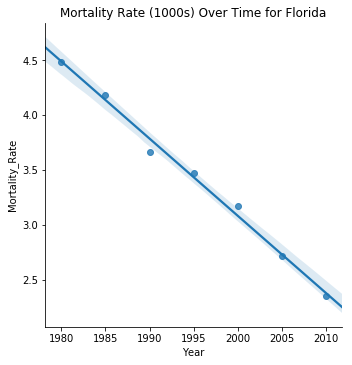

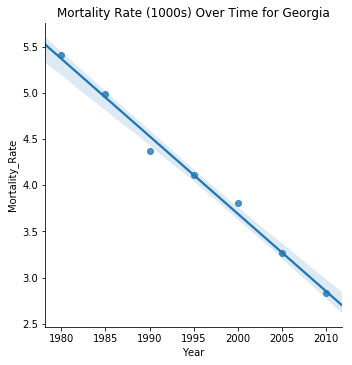

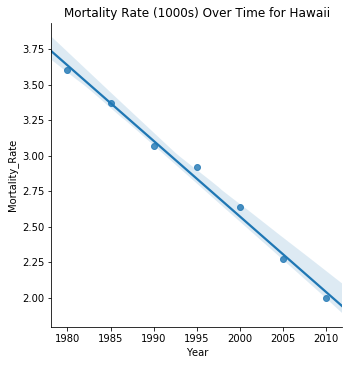

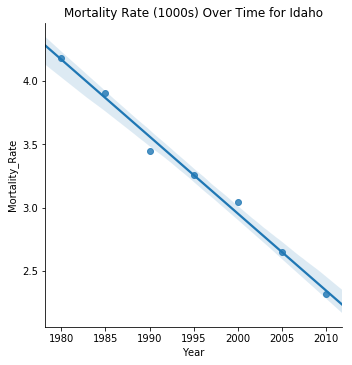

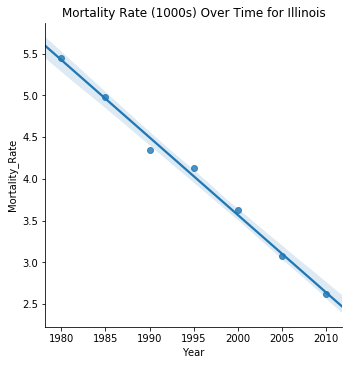

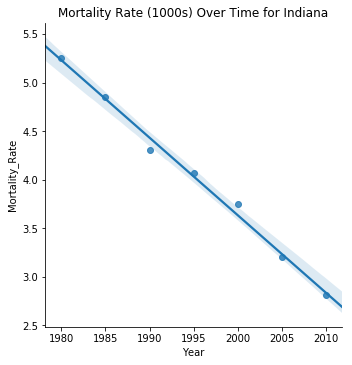

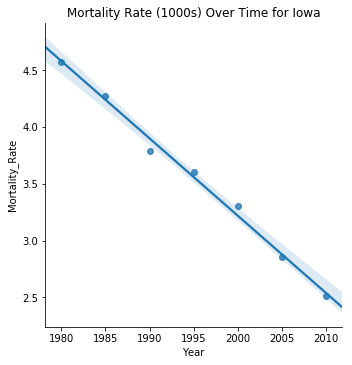

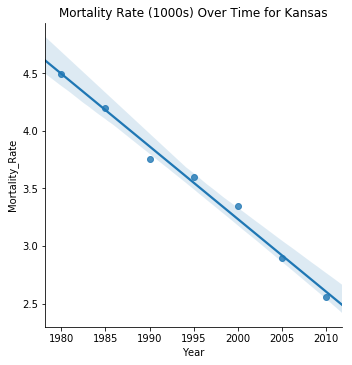

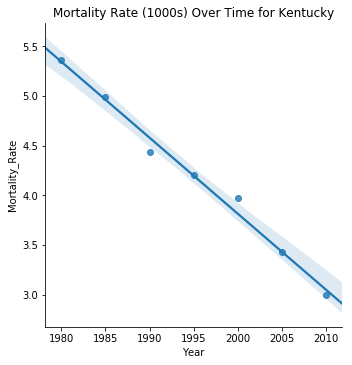

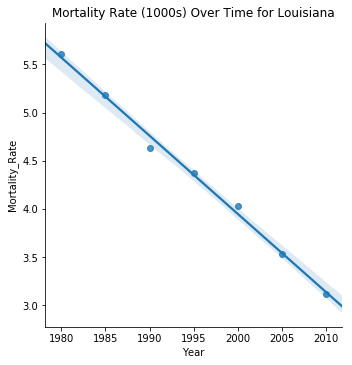

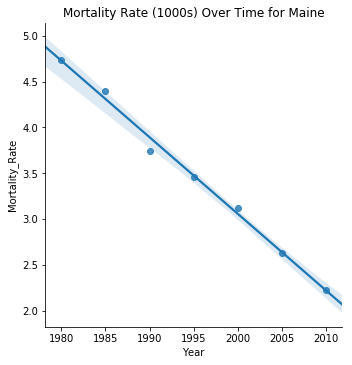

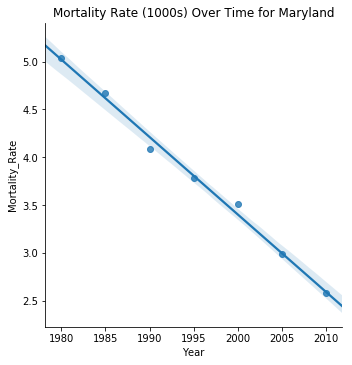

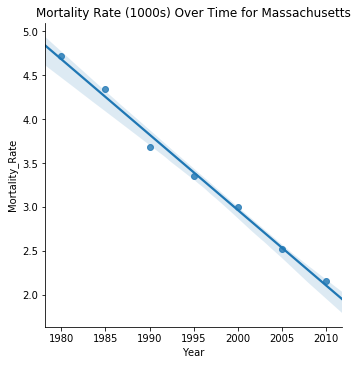

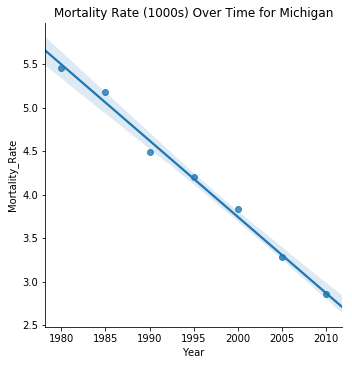

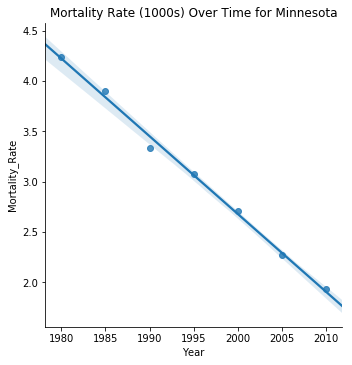

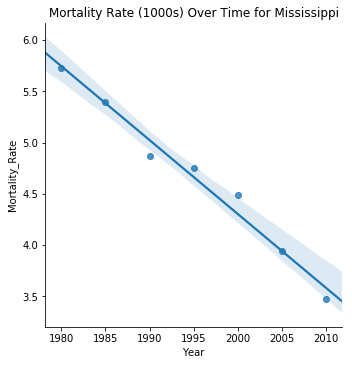

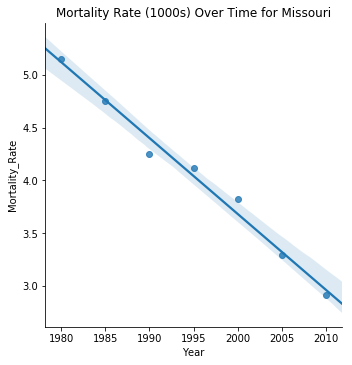

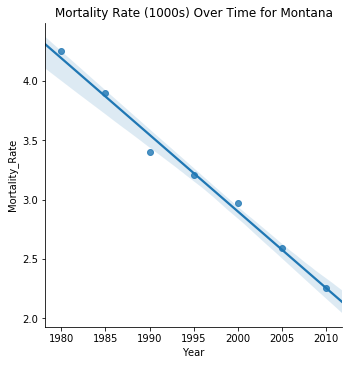

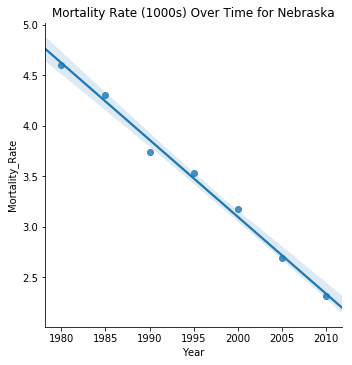

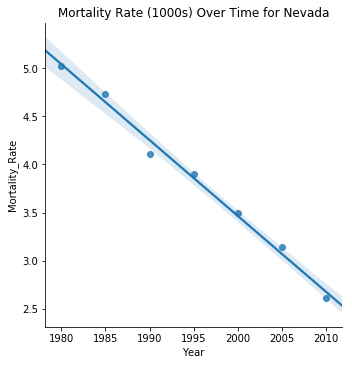

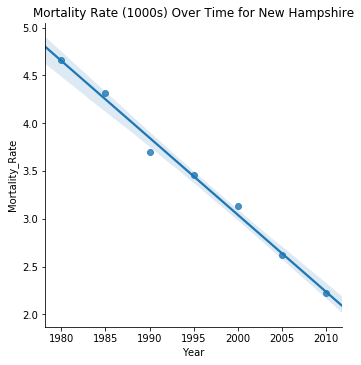

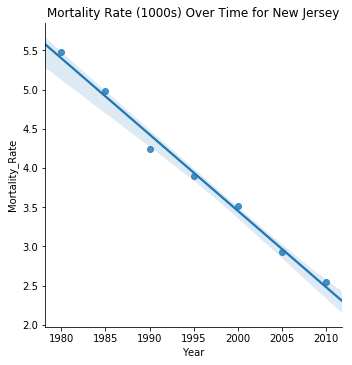

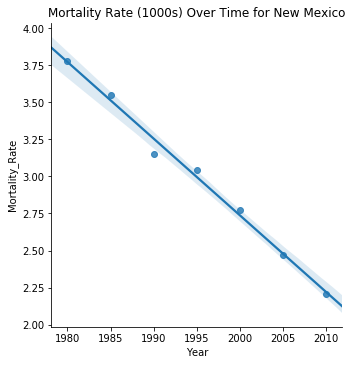

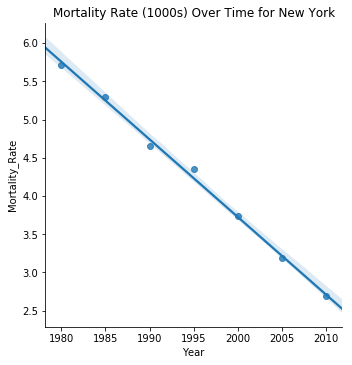

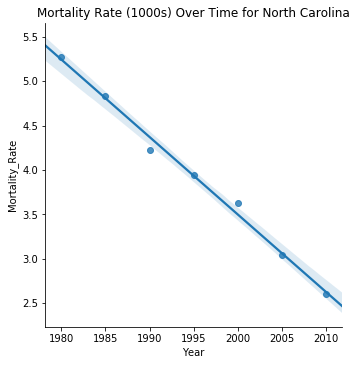

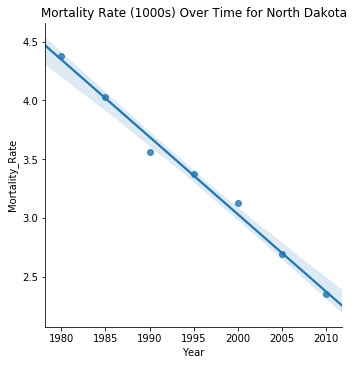

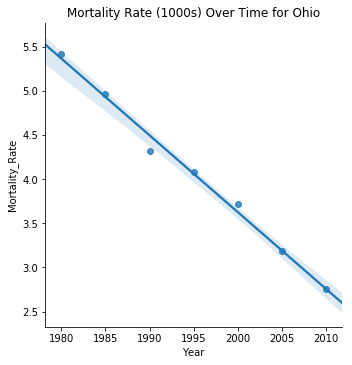

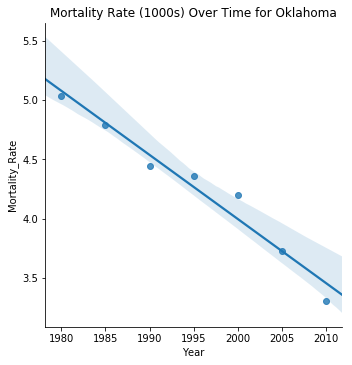

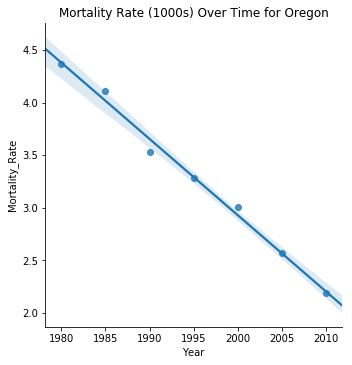

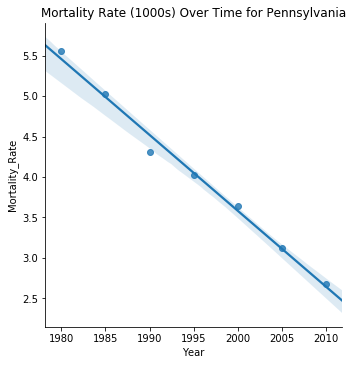

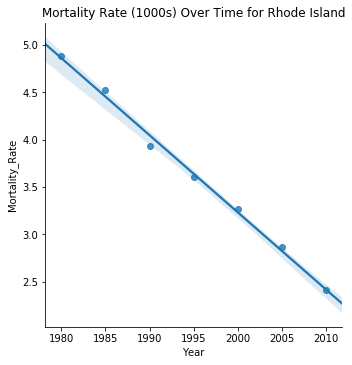

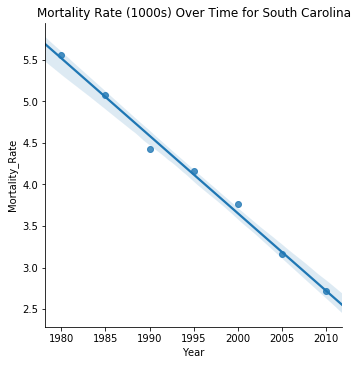

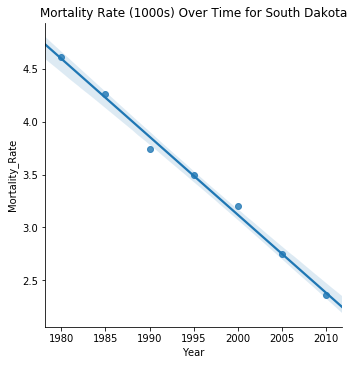

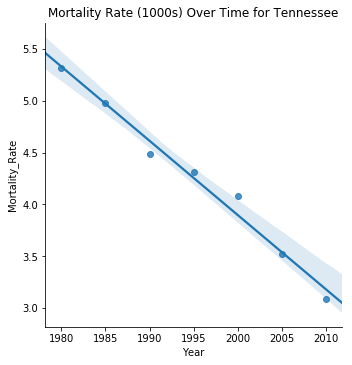

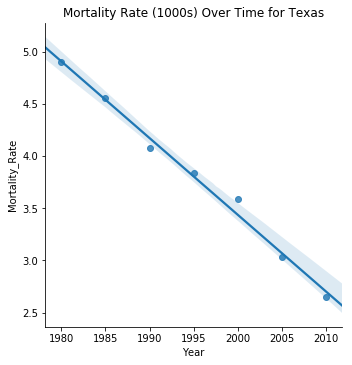

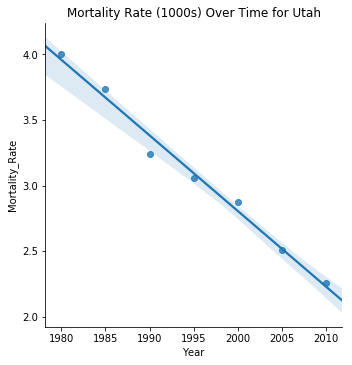

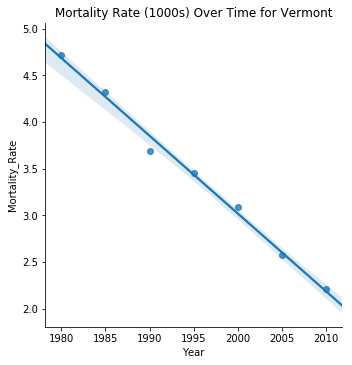

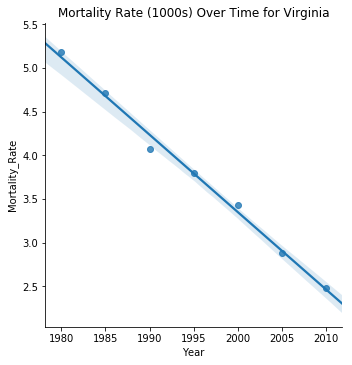

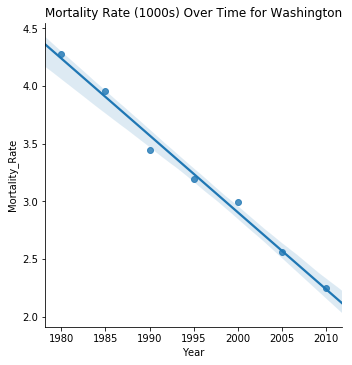

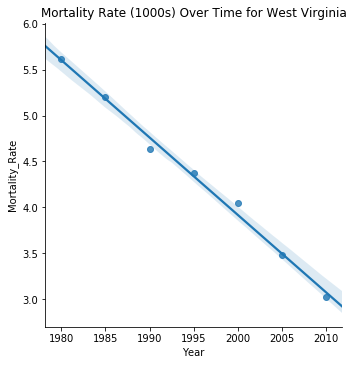

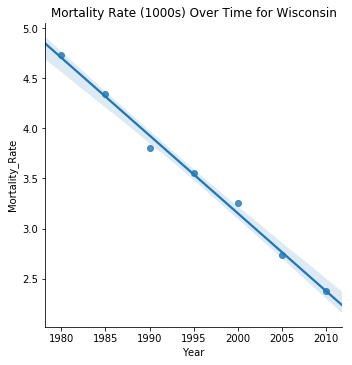

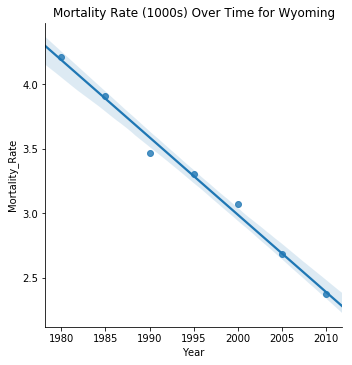

In [5]:
# Get all the unique state values.
states = sorted(list(set(data['STATE'])))

for state in states:
    state_rates = data.loc[data.loc[:, 'STATE'] == state, ['Year', 'Mortality_Rate']]
    g1 = sns.lmplot('Year', 'Mortality_Rate', data=state_rates)
    title = 'Mortality Rate (1000s) Over Time for ' + state
    plt.title(title)
    plt.show()

It's clear that each state has a strong downward trend in mortality rates.

Now let's graph the mortality rate vs the poverty rate.

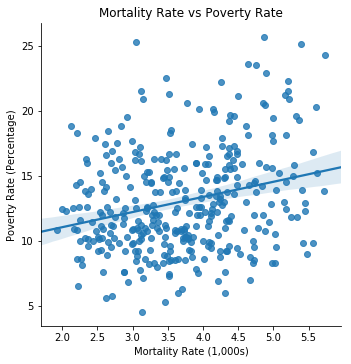

In [6]:
g2 = sns.lmplot('Mortality_Rate', 'Poverty_Rate', data=data)
plt.title('Mortality Rate vs Poverty Rate')
plt.ylabel('Poverty Rate (Percentage)')
plt.xlabel('Mortality Rate (1,000s)')
plt.show()

There does not seem to be a strong correlation between the mortality rate and poverty rate.  We will have to perform statistical tests between the two to be sure.

Now let's graph the pure population number vs mortality.  

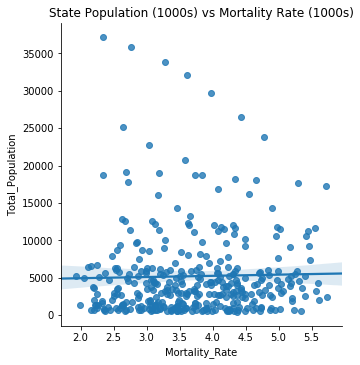

In [7]:
g3 = sns.lmplot('Mortality_Rate', 'Total_Population', data=data)
plt.title('State Population (1000s) vs Mortality Rate (1000s)')
plt.show()

There seems to be little to no correlation between the State population and the mortality rate.

# Variable Pairwise Correlations

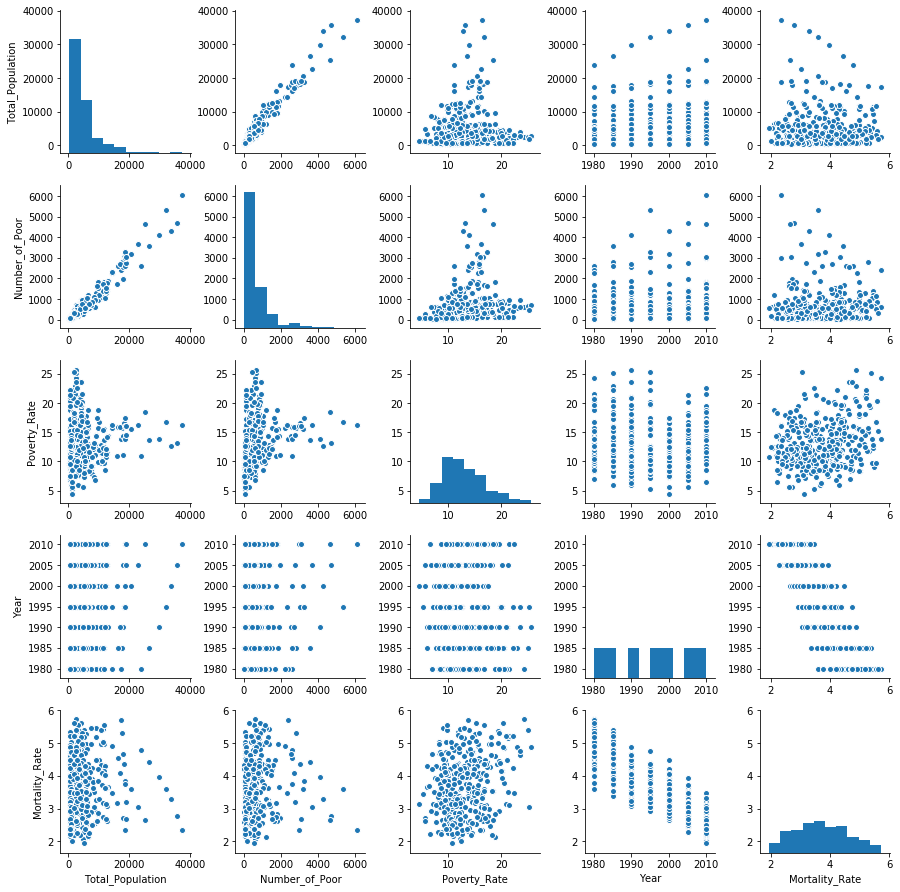

In [8]:
# Plot all pairwise combinations
g4 = sns.pairplot(data)
plt.show()

The only variable with an apparent correlation with the mortality rate is the year variable.

# Statistically Significant Variables
Due to the low amount of variables, we can calculate the pearson coefficient for each possible pair excluding the state names.

In [18]:
correlations = {}
columns = data.columns.drop('STATE').tolist()

for a,b in itertools.combinations(columns, 2):
    correlations[a + '->' + b] = pearsonr(data.loc[:, a], data.loc[:, b])

result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ["Pearson_Correlation", 'Statistical_Significance']

print(result.sort_index())

                                  Pearson_Correlation  \
Number_of_Poor->Mortality_Rate               0.040514   
Number_of_Poor->Poverty_Rate                 0.238056   
Number_of_Poor->Year                         0.093533   
Poverty_Rate->Mortality_Rate                 0.261699   
Poverty_Rate->Year                          -0.055962   
Total_Population->Mortality_Rate             0.024350   
Total_Population->Number_of_Poor             0.970629   
Total_Population->Poverty_Rate               0.075019   
Total_Population->Year                       0.093551   
Year->Mortality_Rate                        -0.855237   

                                  Statistical_Significance  
Number_of_Poor->Mortality_Rate                4.453965e-01  
Number_of_Poor->Poverty_Rate                  5.423412e-06  
Number_of_Poor->Year                          7.757761e-02  
Poverty_Rate->Mortality_Rate                  5.303879e-07  
Poverty_Rate->Year                            2.916570e-01  
Total_

In [19]:
data.corr()

,Total_Population,Number_of_Poor,Poverty_Rate,Year,Mortality_Rate
Total_Population,1.000000,0.970629,0.075019,0.093551,0.024350
Number_of_Poor,0.970629,1.000000,0.238056,0.093533,0.040514
Poverty_Rate,0.075019,0.238056,1.000000,-0.055962,0.261699
Year,0.093551,0.093533,-0.055962,1.000000,-0.855237
Mortality_Rate,0.024350,0.040514,0.261699,-0.855237,1.000000


It seems like the Year variable is the only variable that strongly correlates with the mortality rate.

So we will focus on determing what makes the year variable so important.

## Is there a statistical difference in average Mortality rate between the different years?
Because this is a longitudinal observation on each state, we can not rely on a regular anova test.  We would have to rely on a repeated measures anova test.  However, there is a similar test called a linear mixed effect model that is already implemented in statsmodels, so we'll use that test.

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

md = smf.mixedlm("Mortality_Rate ~ Year", data, groups=data['STATE'])

mdf = md.fit()

print(mdf.summary())

C:\Users\elliot.ting\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Mortality_Rate
No. Observations: 357     Method:             REML          
No. Groups:       51      Scale:              0.0222        
Min. group size:  7       Likelihood:         60.7913       
Max. group size:  7       Converged:          Yes           
Mean group size:  7.0                                       
------------------------------------------------------------
               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     154.859    1.575  98.323 0.000 151.772 157.946
Year           -0.076    0.001 -96.043 0.000  -0.077  -0.074
groups RE       0.192    0.283                              



There is a statistical difference in the average mortality rate between the different years.



## Is there a statistical significant difference between the regions where the states are located?

This result gave us a bit of inspiration and we decided to create a new variable by splitting all the states into their geographic regions and then comparing their mortality rates.

We will follow the US Census specifications.

In [12]:
northeast = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 
             'New Jersey', 'New York', 'Pennsylvania']
midwest = ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 
          'Missouri', 'Nebraska', 'North Dakota', 'South Dakota']
south = ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia',
        'D.C.', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 
         'Louisiana', 'Oklahoma', 'Texas']
west = ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska',
       'California', 'Hawaii', 'Oregon', 'Washington']

regions = [northeast, midwest, south, west]
data.loc[:, 'Region'] = ''

In [21]:
# Northeast states equal 0, midwest = 1, south = 2, west = 3
for i, region in enumerate(regions):
    data.loc[data['STATE'].isin(region), 'Region'] = i
    
# Compare the average mortality rate for each region.
md = smf.mixedlm("Mortality_Rate ~ Year + Poverty_Rate", data, groups=data['Region'])

mdf = md.fit()

print(mdf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Mortality_Rate
No. Observations: 357     Method:             REML          
No. Groups:       4       Scale:              0.0977        
Min. group size:  63      Likelihood:         -109.6980     
Max. group size:  119     Converged:          Yes           
Mean group size:  89.2                                      
------------------------------------------------------------
               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     153.331    3.316  46.239 0.000 146.832 159.831
Year           -0.075    0.002 -45.348 0.000  -0.078  -0.072
Poverty_Rate    0.026    0.005   5.310 0.000   0.017   0.036
groups RE       0.101    0.268                              

